---
title: Sanitization Process for Data Privacy
authors:
- Juan Zinser 
tags:
- knowledge-sharing
- data
- privacy
created_at: 2018-01-30
updated_at: 2018-01-30
tldr: This is short description of the content and findings of the post.
---

# Data Sanitization
As good as data can be now a days, it must satisfy several requirements for it to be made public. A natural trade-off arises between privacy and utility of a dataset. On one side, depending on regulations and the data-holder carefulness, data satisfies certain privacy concerns to prevent sensitive information from being revealed. On the other side, for inference and conclusions to be taken from a dataset, data should be available for people whose interest is to analyze it. These analysis rely on data quality, and the more, the better for it's users. Work has been done to make sure data follows the corresponding privacy constraints, by generalization, suppression or sanitization techniques, with the aim of making data less informative (more private). The purpose of this work is to explore new ways of sanitization for databases and to measure their performance.

Data privacy exists because making data public is important, and it has to be taken care of before making it public. Open-Data is a term that refers to the action of Public or Private Institutions making their Data Public, and usually it helps to improve public policy and public services. An open data culture enhaces collaboration, participation and social innovation European Data Portal and Janssen, Marijin et al.

## Operator Description
The following corresponds to the code for the sanitization operator that will be used on some examples in the following chapters, and in the meantime is useful to mention some theoretical considerations.
Of particular interest are the parameters of the operator function (the privacy level; if real is included or not; and the sanitization distributions $s_1$ and $s_2$) which corresponds to the points of interest in this research.

In [25]:
import numpy as np

def weights_to_probabilities(weights_vector, sum_to=1.):
    if sum(weights_vector) > 0:
        return np.array([sum_to * float(i) / sum(weights_vector) for
                         i in weights_vector])
    else:
        return weights_vector

def entry_sanitization(entry, real_prob, class_length,
                       maybe, uniform, uniform2, include_real,
                       privacy, order_weights, key_to_order,
                       order_exception, ordered_weights):
    """
    Sanitizes a single record

    :param entry:
    :param real_prob:
    :param class_length:
    :param maybe:
    :param uniform:
    :param uniform2:
    :param include_real:
    :param privacy:
    :param order_weights:
    :param key_to_order:
    :param order_exception:
    :param ordered_weights:
    :return:
    """
    # initializes the entry_vector, same size as the
    # total number of classes
    privacy_fraction = 1. / privacy
    entry_vector = np.zeros(class_length)
    if not maybe:
        # gets the weights of each class excluding the real
        # value class
        weights = [1. / (class_length - 1)] * \
                  (class_length - 1) if uniform else \
            order_weights[key_to_order[entry]]

        # makes the weights sum one
        weights = weights_to_probabilities(weights)

        # get sample of the indexes that will have a
        # non zero weight (real not considered)
        non_real_weights = np.random.choice(
            order_exception[key_to_order[entry]],
            privacy - include_real, False, p=weights)

        # save the corresponding weights into their
        # corresponding index for all the sampled
        # indexes in the previous step
        entry_vector[non_real_weights] = privacy_fraction if \
            uniform2 else [ordered_weights[i] for
                           i in non_real_weights]

        # if real prob is None set to the proportional weight
        real_prob = ordered_weights[key_to_order[entry]] if \
            real_prob is None else real_prob

        # gets the weight that will be assigned to
        # the real value
        real_value = (privacy_fraction if uniform2 else
                      real_prob) if include_real else 0
        entry_vector = weights_to_probabilities(
            entry_vector, 1 - real_value)

        entry_vector[key_to_order[entry]] = real_value
        entry_vector = weights_to_probabilities(entry_vector)
    else:
        # gets the weights of each class excluding the
        # real value class
        weights = [1. / class_length] * class_length if \
            uniform else ordered_weights

        # get sample of the indexes that will have a non
        # zero weight
        selected_weights = np.random.choice(
            list(range(class_length)), privacy,
            False, p=weights)

        # save the corresponding weights into their
        # corresponding index
        # for all the sampled indexes in the previous step
        entry_vector[selected_weights] = privacy_fraction if \
            uniform2 else [ordered_weights[i]
                           for i in selected_weights]
        entry_vector = weights_to_probabilities(entry_vector)

    return entry_vector


def operator_model(original_list, privacy=3, include_real=True,
                   uniform=True, uniform2=True, real_prob=None,
                   maybe=False):
    """
    :param original_list:
    :param privacy:
    :param include_real:
    :param uniform:
    :param uniform2:
    :param real_prob: if uniform is false and include_real true,
    the real value will be given this probability
    :param maybe: if the maybe is true, include real is ignored
    :return:
    """
    # gets the real frequencies and calculates the changes 
    # for the new_value for each possible case
    counts = Counter(original_list)
    total = sum(counts.values())
    class_length = len(counts)
    privacy = min(privacy, class_length)
    if (privacy - include_real) >= class_length:
        include_real = True
    privacy_fraction = 1. / privacy

    # correspondence of the ordered index of each of the classes
    key_to_order = dict(zip(sorted(counts.keys()),
                            range(class_length)))
    order_exception = dict()
    order_weights = dict()
    ordered_weights = [float(counts[key]) / total for
                       key in sorted(counts.keys())]

    # gets two dictionaries, order exception and ordered weights
    for key in range(class_length):
        all_non_entry = list(range(class_length))
        all_non_entry.pop(key)
        all_non_entry_ordered_weights = [ordered_weights[i] for
                                         i in all_non_entry]
        
        # order exception has a list off all the indexes 
        # other than the one of the real value, after 
        # being ordered
        order_exception[key] = all_non_entry
        # order weights contains the equivalent to order 
        # exception but with the corresponding weights instead
        order_weights[key] = all_non_entry_ordered_weights

    negative_list = [entry_sanitization(
        i, real_prob, class_length, maybe, uniform, uniform2,
        include_real, privacy, order_weights, key_to_order,
        order_exception, ordered_weights) 
        for i in original_list]

    result_dict = dict()
    for idx, field in enumerate(sorted(counts.keys())):
        result_dict[field] = [i[idx] for i in negative_list]

    return result_dict

## Analyse the Supervised Set

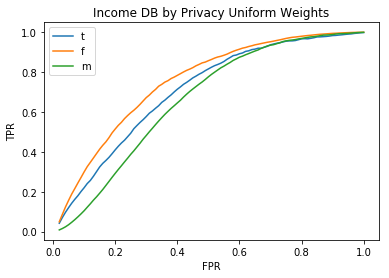

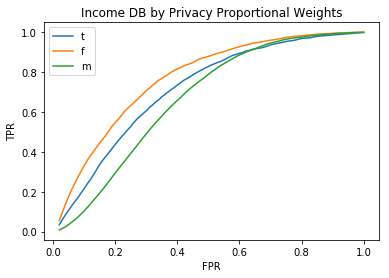

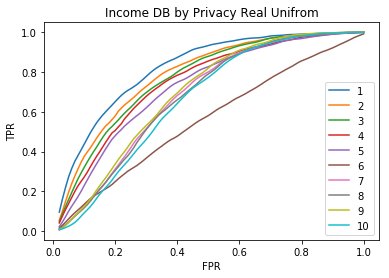

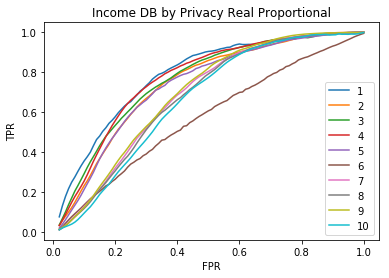

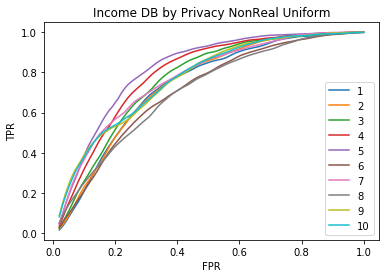

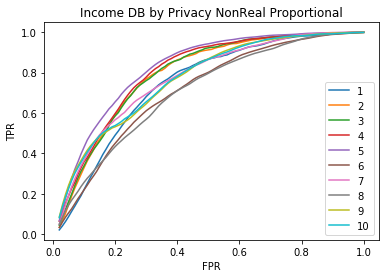

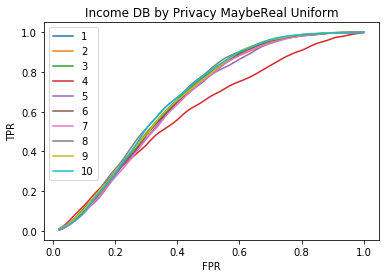

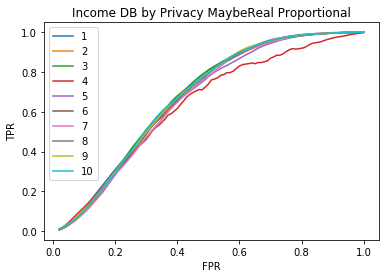

In [12]:
from sanitization_tools import *

supervised_results = pn.read_csv("model_scores_roc.csv")

rocs_by_case(supervised_results, {"uniform":1, "uniform2":1},{"real":["t","f","m"]}, savefig=True, title="by Privacy Uniform Weights", save_name="income_roc_privacy_grouped_tmf_1")
rocs_by_case(supervised_results, {"uniform":0, "uniform2":0},{"real":["t","f","m"]}, savefig=True, title="by Privacy Proportional Weights", save_name="income_roc_privacy_grouped_tmf_0")
rocs_by_case(supervised_results, {"real":"t", "uniform":1, "uniform2":1},{"privacy":[i for i in range(1,11)]}, savefig=False, title="by Privacy Real Unifrom", save_name="income_roc_privacyt1")
rocs_by_case(supervised_results, {"real":"t", "uniform":0, "uniform2":0},{"privacy":[i for i in range(1,11)]}, savefig=False, title="by Privacy Real Proportional", save_name="income_roc_privacyt0")
rocs_by_case(supervised_results, {"real":"f", "uniform":1, "uniform2":1},{"privacy":[i for i in range(1,11)]}, savefig=False, title="by Privacy NonReal Uniform", save_name="income_roc_privacyf1")
rocs_by_case(supervised_results, {"real":"f", "uniform":0, "uniform2":0},{"privacy":[i for i in range(1,11)]}, savefig=False, title="by Privacy NonReal Proportional", save_name="income_roc_privacyf0")
rocs_by_case(supervised_results, {"real":"m", "uniform":1, "uniform2":1},{"privacy":[i for i in range(1,11)]}, savefig=False, title="by Privacy MaybeReal Uniform", save_name="income_roc_privacym1")
rocs_by_case(supervised_results, {"real":"m", "uniform":0, "uniform2":0},{"privacy":[i for i in range(1,11)]}, savefig=False, title="by Privacy MaybeReal Proportional", save_name="income_roc_privacym0")

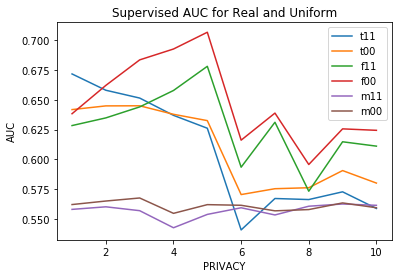

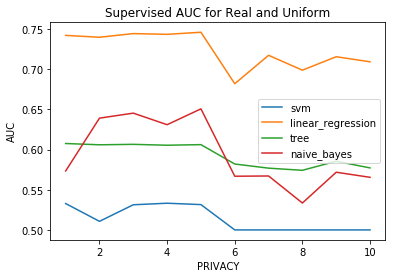

In [2]:
rmse_auc_plot_no_intervals(supervised_results, "privacy", "auc", ["t", "f", "m"], [None], [None], [None], [None],
                           {("uniform","uniform2"):[(1,1),(0,0)]}, savefig=False, 
                           title="Supervised AUC for Real and Uniform", save_name="supervised_auc_gb_tmf_01")

rmse_auc_plot_no_intervals(supervised_results, "privacy", "auc", [None], [None], [None], [None], ["svm", "linear_regression", "tree", "naive_bayes"],
                           savefig=False, title="Supervised AUC for Real and Uniform", save_name="supervised_auc_models")

### AUC Table

In [3]:
auc_sum = supervised_results.groupby(["privacy", "real"])["auc"].mean().reset_index()
auc_pivsum = auc_sum.pivot(index="privacy", columns="real", values="auc" ).round(2)
print(auc_pivsum)

real        f     m     t
privacy                  
1        0.64  0.56  0.64
2        0.66  0.57  0.64
3        0.68  0.57  0.64
4        0.69  0.55  0.64
5        0.71  0.56  0.63
6        0.62  0.56  0.57
7        0.64  0.56  0.58
8        0.60  0.56  0.58
9        0.63  0.56  0.59
10       0.62  0.56  0.58


## Model Comparison

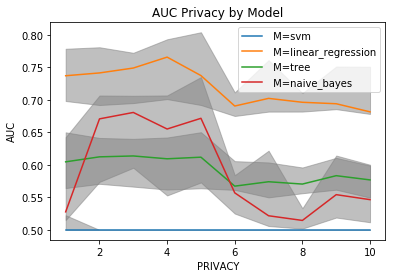

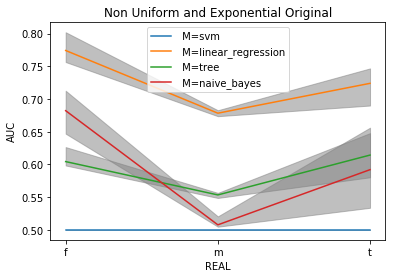

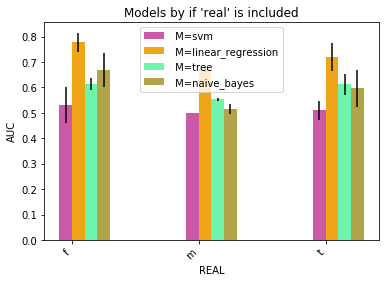

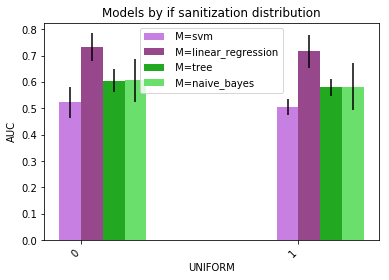

In [6]:
plot_intervals(supervised_results, "privacy","auc", {}, 
               {"model":["svm", "linear_regression", "tree", "naive_bayes"]}, savefig=True, 
               title="AUC Privacy by Model", save_name="auc_model_privacy")

plot_intervals(supervised_results, "real", "auc", {}, 
               {"model":["svm", "linear_regression", "tree", "naive_bayes"]}, savefig=False, 
               title="Non Uniform and Exponential Original", save_name="auc_isreal")

plot_bars(supervised_results, "real", "auc", {}, 
               {"model":["svm", "linear_regression", "tree", "naive_bayes"]}, savefig=False, 
               title="Models by if 'real' is included", save_name="include_real_model", width_delta=.1)

plot_bars(supervised_results, "uniform", "auc", {}, 
               {"model":["svm", "linear_regression", "tree", "naive_bayes"]}, savefig=False,  
               title="Models by if sanitization distribution", save_name="uniform_model", width_delta=.1)

## Analyse the Non-Supervised Set

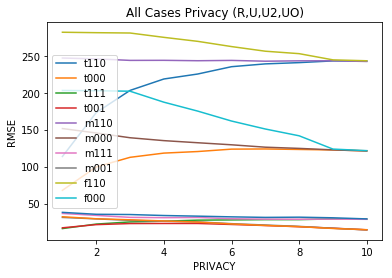

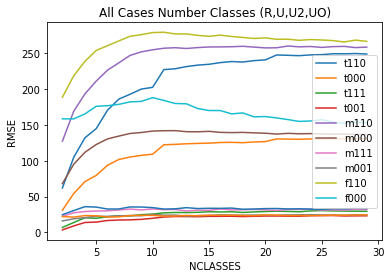

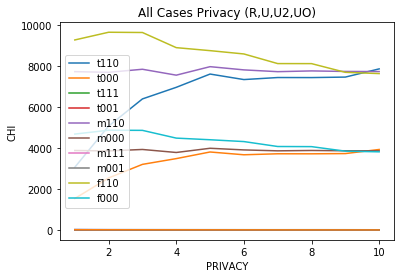

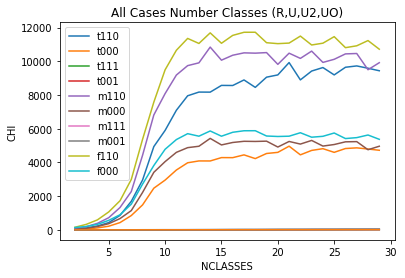

In [7]:
from sanitization_tools import *
non_supervised_results = pn.read_csv("rmse_df_simulated_rel.csv")

rmse_auc_plot_no_intervals(non_supervised_results, "privacy", "rmse", 
                           ["t", "m", "f"], [None], [None], [0,1], [None],
                            {("uniform","uniform2"):[(1,1),(0,0)]}, savefig=True, 
                           title="All Cases Privacy (R,U,U2,UO)", save_name="rmse_privacy")
rmse_auc_plot_no_intervals(non_supervised_results, "nclasses", "rmse", 
                           ["t", "m", "f"], [None], [None], [0,1], [None],
                            {("uniform","uniform2"):[(1,1),(0,0)]}, savefig=True, 
                           title="All Cases Number Classes (R,U,U2,UO)", save_name="rmse_nclasses")
rmse_auc_plot_no_intervals(non_supervised_results, "privacy", "chi", 
                           ["t", "m", "f"], [None], [None], [0,1], [None],
                            {("uniform","uniform2"):[(1,1),(0,0)]}, savefig=True, 
                           title="All Cases Privacy (R,U,U2,UO)", save_name="privacy")
rmse_auc_plot_no_intervals(non_supervised_results, "nclasses", "chi", 
                           ["t", "m", "f"], [None], [None], [0,1], [None],
                            {("uniform","uniform2"):[(1,1),(0,0)]}, savefig=True, 
                           title="All Cases Number Classes (R,U,U2,UO)", save_name="nclasses")

## Number of classes
The following are the plots showing the mean, and the intervals of the mean plus and minus the standard deviation. For the next cases, the chi-square increases with the number of classes, and stabilize after the number of classes goes higher than 10.

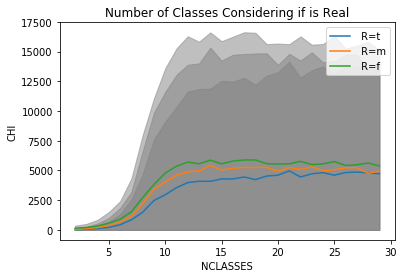

In [15]:
plot_intervals_std(non_supervised_results, "nclasses","chi", {},
                {"real":["t", "m", "f"]}, savefig=True, title="Number of Classes Considering if is Real", save_name="nclasses_isreal")

The include the real value has the lowest chi-square followed by the maybe include the real value. When the real value is not included, the chi-square is the highest of the three.

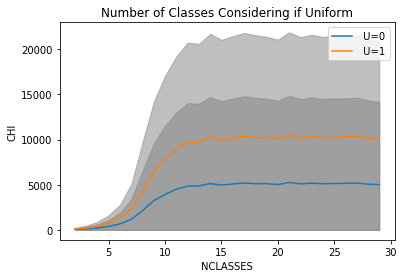

In [16]:
plot_intervals_std(non_supervised_results, "nclasses","chi", {},
                {"uniform":[0,1]}, savefig=True, title="Number of Classes Considering if Uniform", save_name="nclasses_uniform")

When the sanitization distribution is uniform the chi-square is twice as high as when then the proportional distribution is considered.

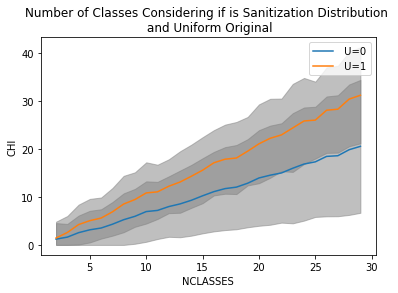

In [17]:
plot_intervals_std(non_supervised_results, "nclasses","chi", {"uniform_original":[1]},
                {"uniform":[0,1]}, savefig=True, title="Number of Classes Considering if is Sanitization Distribution \n and Uniform Original", save_name="nclassses_uniform_original1")

When the original distribution is uniform it is slightly better to use the proportional distribution than the uniform distribution, which should be really close. The difference comes since the proportional distribution captures the difference from the sample values from the theoretical uniform distribution.

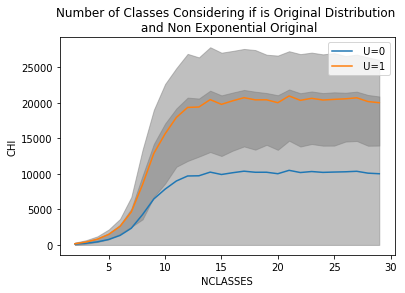

In [18]:
plot_intervals_std(non_supervised_results, "nclasses","chi", {"uniform_original":[0]},
                {"uniform":[0,1]}, savefig=True, title="Number of Classes Considering if is Original Distribution \n and Non Exponential Original", save_name="nclasses_uniform_original0")

When the original distribution is exponential it is twice as better to use the proportional distribution (exponential) in the sanitization process than the uniform distribution.

## Privacy
The privacy level is defined as the number of classes different than zero in the sanitization process multiplied by 10 and divided by the total number of classes.

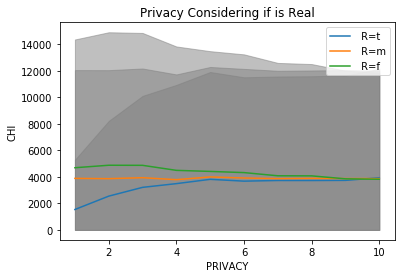

In [19]:
plot_intervals_std(non_supervised_results, "privacy","chi", {},
                {"real":["t", "m", "f"]}, savefig=False, title="Privacy Considering if is Real")

If real value is included is only significant for privacy levels less than 5. Including the real value has a good chi-square error for small privacy levels, while not including the real value has chi-square error bigger than the rest. Maybe including the real value has a steady behavior and can be consider as a random benchmark for the chi-square error than in this case is 4000.

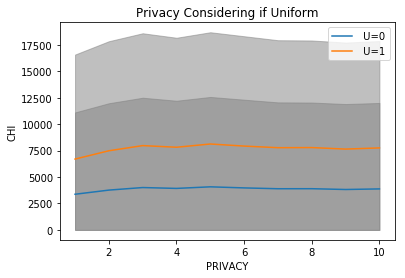

In [20]:
plot_intervals_std(non_supervised_results, "privacy","chi", {},
                {"uniform":[0,1]}, savefig=True, title="Privacy Considering if Uniform", save_name="privacy_uniform")

As in the number of classes plot, when the sanitization distribution is uniform the chi-square is twice as high as when then the proportional distribution is considered. The difference is that the lines are flat, so the privacy level doesn't have a major effect on the behavior of the two sanitization distributions considered.

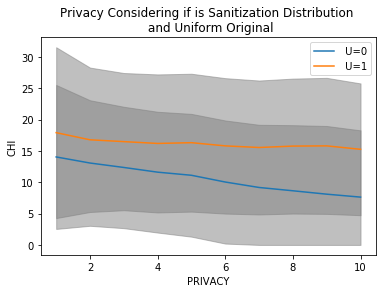

In [21]:
plot_intervals_std(non_supervised_results, "privacy","chi", {"uniform_original":[1]},
                {"uniform":[0,1]}, savefig=True, title="Privacy Considering if is Sanitization Distribution \n and Uniform Original", save_name="privacy_uniform_original1")

The gap between the uniform and proportional distribution chi-square errors increases when the level of privacy increases. The uniform distribution is steady over the level of privacy, while the proportional distribution slightly decreases over the level of privacy.

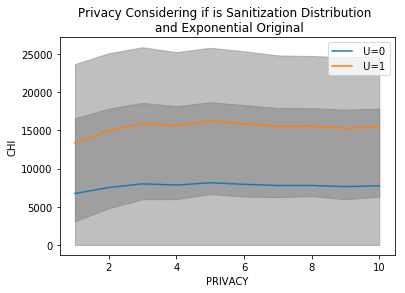

In [22]:
plot_intervals_std(non_supervised_results, "privacy","chi", {"uniform_original":[0]},
                {"uniform":[0,1]}, savefig=True, title="Privacy Considering if is Sanitization Distribution \n and Exponential Original", save_name="privacy_uniform_original0")

Uniform and proportional distributions chi-square errors are steady after a level of privacy of 2. Before 2 they both have a tendency of going up with the uniform distribution having a steeper slope. 

# Conclusions
After analyzing the previous graphs the following can be said. Given the fact that the distribution of the original values is given, a conclusion should come for bot the exponential and uniform distribution of the original values.

There are a few factors to consider to evaluate if there is a gain in the simulations done. First of all is if the chi-square is low for the given case. A low chi-square is good since it tells us that in an overall manner, the value counts are similar. However, besides the level of privacy as was defined below, it is important to consider how easy it is for the attacker to identify a given entry. Also it is important to consider if the attacker or the general public knows the method use for the sanitization, because that will certainly give additional valuable information that will help for the attacker to uncover the information.

Based on the plots of the previous chapters the following can be concluded.
First considering the supervised dataset results:
+ Considering a supervised dataset, a sanitization maybe considering the real value has the worst performance in terms if AUC of the model. Not considering the real value has the best performance and considering the real value has a performance between the two.
+ In the same supervised dataset context analyzing the AUC, when the real value is considered or maybe considered the models have a better performance when using the proportional distribution in the sanitization over the uniform distribution. When the real value is not considered the uniform distribution has a better performance than the proportional.
+ After performing sanitization without including the real value, it is better to use naive bayes classifier over the simple tree classifier. However if the real value is included or maybe is included the tree classifiers has a better performance than the naive bayes classifier.
+ The sanitization distribution doesn't have an effect with the model performance, for the 4 models analyzed (tree, naive bayes, svm and linear regression).

Considering the non-supervised dataset results:
+  When the original data has a non-uniform distribution (exponential in this case) and the sanitization distribution is uniform, the chi-square of the histogram similarity result is the highest, at around 8000.
+ When the original data has a non-uniform distribution (exponential in this case) and the sanitization distribution is proportional to the data (therefore exponential), the chi-square of the histogram similarity is at around 4000.
+ When the original data has a uniform distribution and the sanitization distribution is proportional (therefore similar to uniform), the chi-square of the histogram similarity is close to zero.
+ Having less than 10 total classes, makes less important the choice of the sanitization parameters since the chi-square of the histogram similarity is increasing with the number of classes but close between them. Above 10 classes it convenient to choose proportional distribution when the original values are exponential, which makes sense in the way that uniform values would be distant from the exponential ones, producing different histograms and higher chi-square.
+ When the level of privacy is higher that 40% (percentage of total number of classes), the is real parameter has a small effect, since chi-square results converge with privacy levels higher that that one.

The possible future work might include analyzing the effect of changing the two distributions $s_1$ and $s_2$, this means that the distribution from which the class values are sampled and the distribution that assigns the weights to the sample values might be different. As a remainder the two distributions are included as parameters of the operator, but for this work only the case where both are the same is considered.